# CARTOframes with Dask

This notebook recreate the workflow from <https://jakevdp.github.io/blog/2015/08/14/out-of-core-dataframes-in-python/>, where the author explores [`dask`](http://dask.pydata.org/en/latest/) for splitting up the computations across multiple cores in a machine to complete tasks more quickly. 

## Basics

You'll need the following for this:

1. Your CARTO username
2. Your API key

Paste these values in the quotes (`''`) below.

In [1]:
%matplotlib inline
import pandas as pd
import cartoframes

username = ''   # <-- insert your username here
api_key = ''    # <-- insert your API key here

cc = cartoframes.CartoContext('https://{}.carto.com/'.format(username),
                              api_key)

In [2]:
from dask import dataframe as dd
import pandas as pd
columns = ["name", "amenity", "Longitude", "Latitude"]
data = dd.read_csv('scratch/POIWorld.csv', usecols=columns)

In [3]:
with_name = data[data.name.notnull()]
with_amenity = data[data.amenity.notnull()]

is_starbucks = with_name.name.str.contains('[Ss]tarbucks')
is_dunkin = with_name.name.str.contains('[Dd]unkin')

starbucks = with_name[is_starbucks].compute()
dunkin = with_name[is_dunkin].compute()

In [4]:
starbucks['type'] = 'starbucks'
dunkin['type'] = 'dunkin'
coffee_places = pd.concat([starbucks, dunkin])
coffee_places.head(20)

,name,amenity,Longitude,Latitude,type
6696,Starbucks,cafe,121.035006,14.547281,starbucks
8322,Starbucks Coffee,cafe,120.978371,14.578929,starbucks
9505,星巴克咖啡 Starbucks,cafe,120.135887,30.271254,starbucks
12417,星巴克咖啡 Starbucks,cafe,120.158464,30.253061,starbucks
12418,星巴克咖啡 Starbucks,cafe,120.157341,30.256555,starbucks
28564,Starbucks,cafe,-76.934625,40.238707,starbucks
33017,Starbucks,cafe,-1.545032,53.797463,starbucks
36552,Starbucks Coffee,cafe,-79.390940,43.649976,starbucks
37719,Starbucks Coffee,cafe,-79.389462,43.645361,starbucks
40437,Starbucks Coffee,cafe,-79.393634,43.670435,starbucks


## Write DataFrame to CARTO

In [5]:
# specify columns for lng/lat so carto will create a geometry
cc.write(coffee_places,
         table_name='coffee_places',
         lnglat=('longitude', 'latitude'),
         overwrite=True)

The following columns were changed in the CARTO copy of this dataframe:
Longitude -> longitude
Latitude -> latitude
Table successfully written to CARTO: https://cartoframes.carto.com/dataset/coffee_places


### Let's visualize this DataFrame

Category map on Dunkin' Donuts vs. Starbucks (aka, color by 'type')

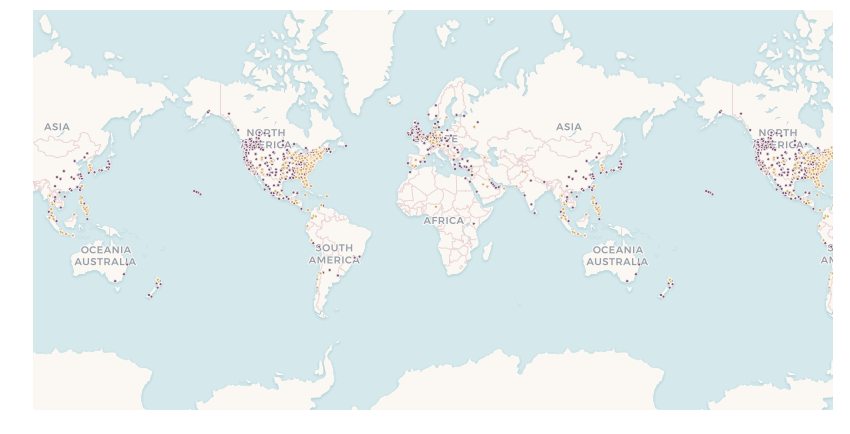

In [6]:
from cartoframes import Layer
cc.map(layers=Layer('coffee_places', color='type', size=3))

## Fast Food

In [7]:
is_fastfood = with_amenity.amenity.str.contains('fast_food')
fastfood = with_amenity[is_fastfood]
fastfood.name.value_counts().head(12)

McDonald's        8697
Subway            7058
Burger King       3226
KFC               2881
Wendy's           1304
Taco Bell         1282
Pizza Hut         1014
マクドナルド             927
Dairy Queen        745
Domino's Pizza     724
McDonalds          619
Arby's             609
Name: name, dtype: int64

In [8]:
ff = fastfood.compute()
cc.write(ff,
         table_name='fastfood_dask',
         lnglat=('longitude', 'latitude'), overwrite=True)

The following columns were changed in the CARTO copy of this dataframe:
Longitude -> longitude
Latitude -> latitude
Table successfully written to CARTO: https://cartoframes.carto.com/dataset/fastfood_dask
`the_geom` column is being populated from `('longitude', 'latitude')`. Check the status of the operation with:
    BatchJobStatus(CartoContext(), 'd2bc4e92-b1d5-4c7d-a8d7-d5a47eddea0f').status()
or try reading the table from CARTO in a couple of minutes.
Note: `CartoContext.map` will not work on this table until its geometries are created.


BatchJobStatus(job_id='d2bc4e92-b1d5-4c7d-a8d7-d5a47eddea0f', last_status='pending', created_at='2017-12-05T14:25:06.748Z')

### Number of Fast Food places in this OSM dump

In [9]:
len(ff)

152214

### OSM Fast Food POIs

In [11]:
from cartoframes import BaseMap
cc.map(layers=Layer('fastfood_dask', size=2))

### Adding measures from the Data Observatory

We can augment our datasets to find out some demographics at the areas of each of the coffee places if you wanted to add features for building a model.

In [12]:
# DO measures: Total Population,
#              Children under 18 years of age
#              Median income

data_obs_measures = [{'numer_id': 'us.census.acs.B01003001'},
                     {'numer_id': 'us.census.acs.B17001001'},
                     {'numer_id': 'us.census.acs.B19013001'}]
coffee_augmented = cc.data('coffee_places', data_obs_measures)
coffee_augmented.head()

,amenity,index,latitude,longitude,median_income_2010_2014,median_income_2011_2015,name,pop_determined_poverty_status_per_sq_km_2010_2014,pop_determined_poverty_status_per_sq_km_2011_2015,the_geom,total_pop_per_sq_km_2010_2014,total_pop_per_sq_km_2011_2015,type
cartodb_id,,,,,,,,,,,,,
6,cafe,28564,40.238707,-76.934625,62842.0,63415.0,Starbucks,881.868363,873.056479,0101000020E61000007D2079E7D03B53C005EBEEF08D1E...,996.366180,991.577729,starbucks
26,cafe,65532,35.079845,-106.606866,34140.0,32838.0,Starbucks,869.520635,871.745312,0101000020E61000001CA43BE3D6A65AC0A11EEC5E388A...,929.112813,932.249243,starbucks
42,cafe,93071,44.039946,-88.541166,39996.0,40665.0,Starbucks,687.264493,686.831843,0101000020E61000004E0E9F74A22256C092CD55F31C05...,854.267385,840.552380,starbucks
61,cafe,143097,37.367685,-122.036460,122354.0,125488.0,Starbucks,3211.407801,3278.440419,0101000020E6100000CFC7105B55825EC0D45D7E4C10AF...,3238.971520,3308.291340,starbucks
69,cafe,169680,39.953015,-75.192289,18933.0,20483.0,Starbucks,4855.675567,4977.608287,0101000020E610000067B96C744ECC52C0910E0F61FCF9...,6558.800331,6725.720324,starbucks
